<a href="https://colab.research.google.com/github/mk7exe/millerite/blob/master/Phase3/Millerite_NN_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import h5py
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
import datetime

import matplotlib.pyplot as plt
%matplotlib inline


Loading the dataset to evaluate from Github.

In [13]:
! wget -nv https://github.com/mk7exe/millerite/raw/master/Phase2/datasets/surf_dataset.h5
root_path = '.'
dataset = h5py.File(root_path + '/surf_dataset.h5', "r")
x_orig = np.array(dataset["test_set_x"][:]).T 
y_orig = np.array(dataset["test_set_y"][:]) 

2020-04-07 22:14:08 URL:https://raw.githubusercontent.com/mk7exe/millerite/master/Phase2/datasets/surf_dataset.h5 [6464/6464] -> "surf_dataset.h5.2" [1]


(8, 68) (8, 1) (8, 1) (8, 1)


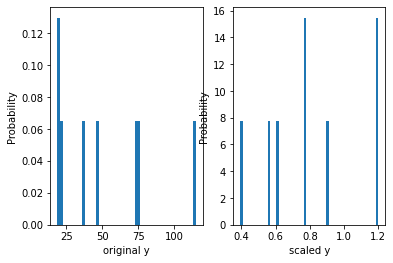

In [14]:
xsum = np.sum(x_orig, axis=1, keepdims=True)

y_orig = y_orig.reshape((x_orig.shape[0], 1))
y_temp = np.divide(y_orig, xsum)

print(x_orig.shape, y_orig.shape, xsum.shape, y_temp.shape)

plt.figure()
plt.subplot(1,2,1)
# the histogram of the data
n, bins, patches = plt.hist(y_orig, 50, density=True)
plt.xlabel('original y')
plt.ylabel('Probability')
plt.subplot(1,2,2)
# the histogram of the data
n, bins, patches = plt.hist(y_temp, 50, density=True)
plt.xlabel('scaled y')
plt.ylabel('Probability')
plt.show()

y_orig = y_temp

Mounting google drive to load trained model.

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Defining the model to load (in case there are multiple models saved in Google Drive)

In [0]:
drive_path = 'gdrive/My Drive/Colab Notebooks/models'
model_date = '20200407-221212'
model_path = drive_path + '/' + model_date

Getting feature scalling parameters from Google Drive

In [0]:
xmean_path = model_path + '/xmean.txt'
xmean = np.genfromtxt(xmean_path, delimiter=',')

xrange_path = model_path + '/xrange.txt'
xrange = np.genfromtxt(xrange_path, delimiter=',')

y_path = model_path + '/ymean_yrange.txt'
with open(y_path) as f:
  lines=f.readlines()
  temp = lines[1].split()
  ymean = temp[0]
  yrange = temp[1]

Applying the feature scaling to x

In [0]:
x = np.divide(np.subtract(x_orig, xmean), xrange)

Defining the model

In [0]:
hparams = {
    'num_layers': 3,
    'num_units': 60,
    'dropout': 0.1,
    'alpha': 0.0001,
    'lambdaL2': 0.01,
    'last_activation': 'linear',
    'activation': 'relu'
    }

def train_model(hparams):
  num_layers = hparams['num_layers']
  num_units = hparams['num_units']
  activation = hparams['activation']
  lambdaL2 = hparams['lambdaL2']
  dropout = hparams['dropout']
  learning_rate = hparams['alpha']  
  out_activation = hparams['last_activation']

  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=x.shape[1:]))

  for i in range(num_layers):
    model.add(keras.layers.Dense(num_units, kernel_regularizer=
                               keras.regularizers.l2(lambdaL2), use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(activation))
    model.add(keras.layers.Dropout(dropout))

  model.add(keras.layers.Dense(1, activation=out_activation))

  adam = keras.optimizers.Adam(learning_rate=learning_rate,
                               beta_1=0.9, beta_2=0.999) 
  model.compile(optimizer=adam, 
                loss=keras.losses.mean_squared_error, 
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model

Loading the model

In [20]:
model = train_model(hparams)
model_name = model_path + '/model'
model.load_weights(model_name)

In [21]:
y_pred = model.predict(x)
# yrange = float(yrange)
# ymean = float(ymean)

# y_bar = np.multiply(y_pred, yrange) + ymean 
#y_bar = np.multiply(y_bar, xsum)

RMSE = np.sqrt(np.mean(np.square(np.subtract(y_bar, y_orig))))

for i in range(len(y_pred)):
  print(y_bar[i], y_orig[i], np.divide(np.abs(y_bar[i])-np.abs(y_orig[i]), 
        y_orig[i]))

print("RMSE= ", RMSE)

[0.9360823] [0.77687733] [0.20492935]
[0.9117574] [0.56026271] [0.62737478]
[0.9973136] [0.90717105] [0.09936668]
[0.9378741] [1.19981842] [-0.21831998]
[0.7451179] [0.774958] [-0.03850544]
[1.0459127] [1.18668822] [-0.11862887]
[1.0402862] [0.39149342] [1.65722523]
[0.9030404] [0.61762973] [0.46210644]
RMSE=  0.30592783823057657
